# NSL-KDD - Multi-class Classification

By: Luis David Garcia

Part of my final project for the course is to implement a hybrid Autoencoder-XGBoost learning model to classify network traffic data for distributed denial of serivce (DDoS) attacks. The dataset used is the NSL-KDD dataset, which is a modified version of the KDD Cup 1999 dataset. The original dataset was created for the DARPA Intrusion Detection Evaluation Program, and it contains a large number of network traffic data that can be used for intrusion detection.

## Create the Conda Environment

This is likely not necessary if you run the code online in Google Colab, but if you want to run the code locally, you can create a conda environment with the following commands:

In [1]:
#!/bin/bash

# Variables
ENV_NAME="myenv"
PYTHON_VERSION="3.10"

# Create the conda environment
%conda create --name $ENV_NAME python=$PYTHON_VERSION -y
# Initialize the Bash shell for conda environments
!@source "$(conda info --base)/etc/profile.d/conda.sh"
# Activate the conda environment
%conda activate $ENV_NAME

# Install TensorFlow
%conda install -c conda-forge tensorflow -y

# Install scikit-learn and XGBoost
%conda install -c conda-forge scikit-learn xgboost -y

# Install additional libraries
%conda install -c conda-forge numpy pandas matplotlib imbalanced-learn psutil seaborn jupyter -y

# Output success message
!echo "Conda environment '$ENV_NAME' has been set up with all dependencies."


Retrieving notices: ...working... done
Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: / ^C

CondaError: KeyboardInterrupt


Note: you may need to restart the kernel to use updated packages.
zsh:1: command not found: @source

CondaError: Run 'conda init' before 'conda activate'


Note: you may need to restart the kernel to use updated packages.
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Users/lucky/anaconda3/envs/watchtower_env

  added / updated specs:
    - tensorflow


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.8.30  |       hf0a4a13_0         155 KB  conda-forge
    certifi-2024.8.30          |     pyhd8ed1ab_0         160 KB  conda-forge
    conda-24.7.1               |  py310hbe9552e_0         945 KB  conda-forge
    openssl-3.3.2            

## Loading Libraries

In [1]:
# For getting paths
import os

# For data manipulation and preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

# For feature engineering
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# For model building
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For model evaluation
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, classification_report

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For timing
import time

## Dataset Analysis and Cleaning

In [29]:
# Column Labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

# Datasets
train_path = "../datasets/nsl-kdd/KDDTrain+.txt"
test_path = "../datasets/nsl-kdd/KDDTest+.txt"

df_train=pd.read_csv(train_path,header=None,names=columns)
df_test=pd.read_csv(test_path,header=None,names=columns)

In [30]:
# Training Set Preview
print(df_train.shape)
print("--------------------")
print(df_train.head())
print("--------------------")
print(df_train.info())

(125973, 43)
--------------------
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60             

In [31]:
# Testing Set Preview
print(df_test.shape)
print("--------------------")
print(df_test.head())
print("--------------------")
print(df_test.info())

(22544, 43)
--------------------
   duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         0           tcp   private   REJ          0          0     0   
1         0           tcp   private   REJ          0          0     0   
2         2           tcp  ftp_data    SF      12983          0     0   
3         0          icmp     eco_i    SF         20          0     0   
4         1           tcp    telnet  RSTO          0         15     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.04   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.61   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    0.31   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.06                         0.00   
1                    0.06        

### Checks - Duplicates, Missing, Distribution, Types

In [32]:
# Check for duplicates
print("Duplicates in Train: ", df_train.duplicated().sum())
print("Duplicates in Test: ", df_test.duplicated().sum())

# Check for missing values
print("-----------------------------------")
print("Rows with missing values - train: ", df_train.isnull().sum())
print("-----------------------------------")
print("Rows with missing values - test: ", df_test.isnull().sum())

Duplicates in Train:  0
Duplicates in Test:  0
-----------------------------------
Rows with missing values - train:  duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate             

### Training Attack Distribution

-----------------------------------
Distribution of Dataset - train: 
attack
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64


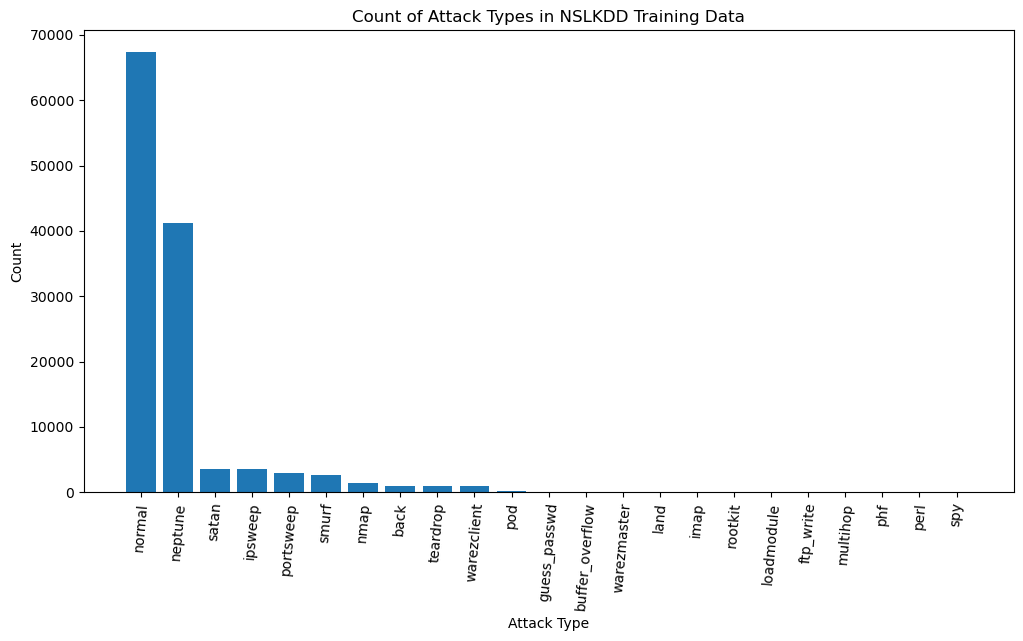

In [33]:
# Check for distribution - Train
print("-----------------------------------")
print("Distribution of Dataset - train: ")
attack_counts_train = df_train['attack'].value_counts()
print(attack_counts_train)

# Create a bar plot
plt.figure(figsize=(12,6))
plt.bar(attack_counts_train.index, attack_counts_train.values)
plt.xticks(rotation=85)
plt.title("Count of Attack Types in NSLKDD Training Data")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.show()

### Testing Attack Distribution

-----------------------------------
Distribution of Dataset - Test: 
attack
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
rootkit              13
xterm                13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
worm                  2
loadmodule            2
perl                  2
sqlattack             2
udpstorm              2
phf                   2
imap                  1
Name: count,

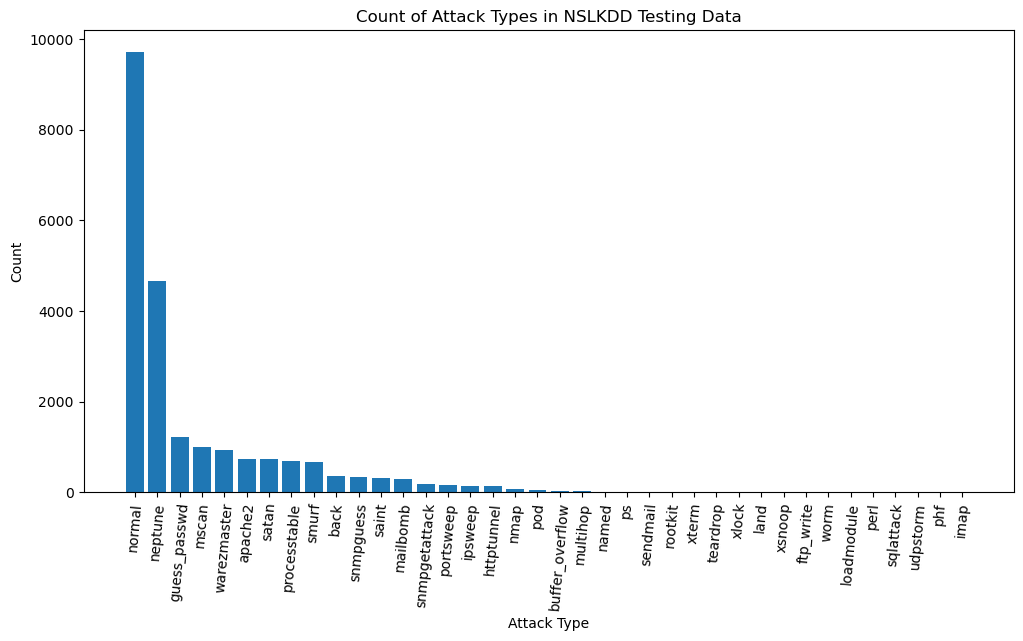

In [34]:
# Check for distribution - Test
print("-----------------------------------")
print("Distribution of Dataset - Test: ")
attack_counts_test = df_test['attack'].value_counts()
print(attack_counts_test)

# Create a bar plot
plt.figure(figsize=(12,6))
plt.bar(attack_counts_test.index, attack_counts_test.values)
plt.xticks(rotation=85)
plt.title("Count of Attack Types in NSLKDD Testing Data")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.show()

### Attack Reduction

#### Multi-class Classification Data

In [40]:
# Must reduce to only attacks known in the training set

# List of DDoS/DoS attacks for the training dataset
train_ddos = [
    "neptune",
    "smurf",
    "pod",
    "teardrop",
    "land",
    "back"
]

# List of DDoS/DoS attacks for the test dataset, including unknowns
test_ddos = [
    "apache2",
    "processtable",
    "mailbomb",
    "udpstorm",
    "worm",
    "processtable"
]

# Combine DDoS/DoS attacks for filtering
all_train_attacks = train_ddos
all_test_attacks = all_train_attacks

# Filtering df_train to keep only 'normal', train_ddos, and scanning attacks
df_train_multiclass = df_train[df_train['attack'].isin(['normal'] + all_train_attacks)]

# Filtering df_test to keep only 'normal' and test_ddos, including known DDoS attacks
df_test_multiclass = df_test[df_test['attack'].isin(['normal'] + all_test_attacks)]

# Group non-DDoS/DoS attacks and scanning attacks in the test set as 'suspicious'
# df_test_multiclass['attack'] = df_test['attack'].apply(
#     lambda x: 'suspicious' if x not in ['normal'] + train_ddos else x
# )

# Displaying the filtered DataFrames
print("Filtered df_train for DDoS and scanning attacks:")
print(df_train_multiclass['attack'].value_counts())

print("-------------------------------")

print("\nFiltered df_test for DDoS (excluding known DDoS attacks):")
print(df_test_multiclass['attack'].value_counts())


Filtered df_train for DDoS and scanning attacks:
attack
normal      67343
neptune     41214
smurf        2646
back          956
teardrop      892
pod           201
land           18
Name: count, dtype: int64
-------------------------------

Filtered df_test for DDoS (excluding known DDoS attacks):
attack
normal      9711
neptune     4657
smurf        665
back         359
pod           41
teardrop      12
land           7
Name: count, dtype: int64


#### Plotting of the Attack Distribution

In [41]:
# Helper function to plot bar labels
def add_bar_labels(bars):
    # Add counts on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height}',
            ha='center',
            va='bottom'
        )

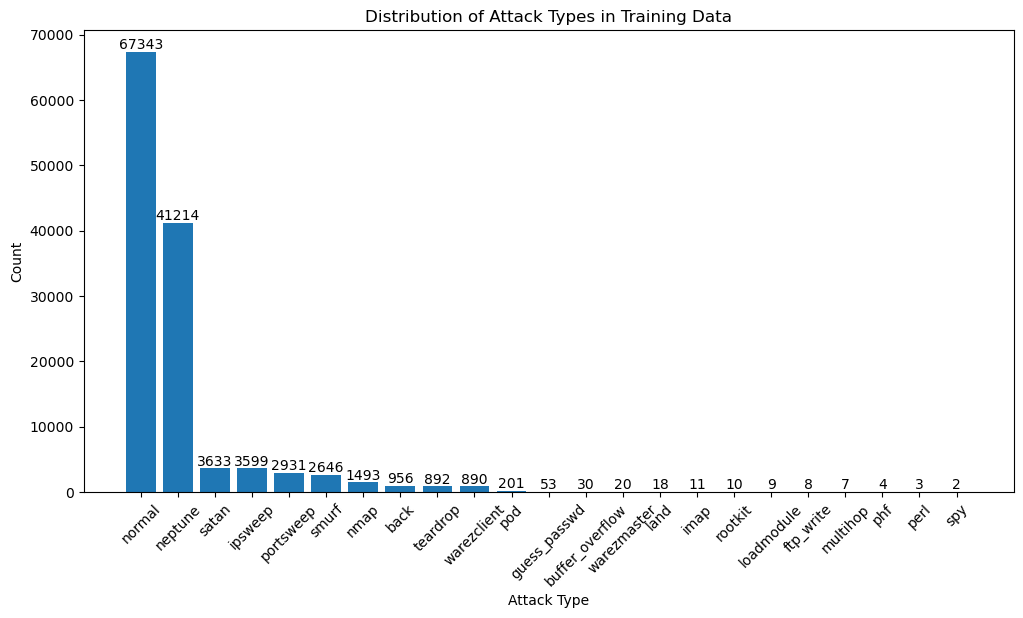

In [42]:
# Plot of Training DDoS Attack Distribution
attack_counts_train = df_train['attack'].value_counts()
plt.figure(figsize=(12, 6))
bars = plt.bar(attack_counts_train.index, attack_counts_train.values)
add_bar_labels(bars)
plt.xticks(rotation=45)
plt.title("Distribution of Attack Types in Training Data")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.show()

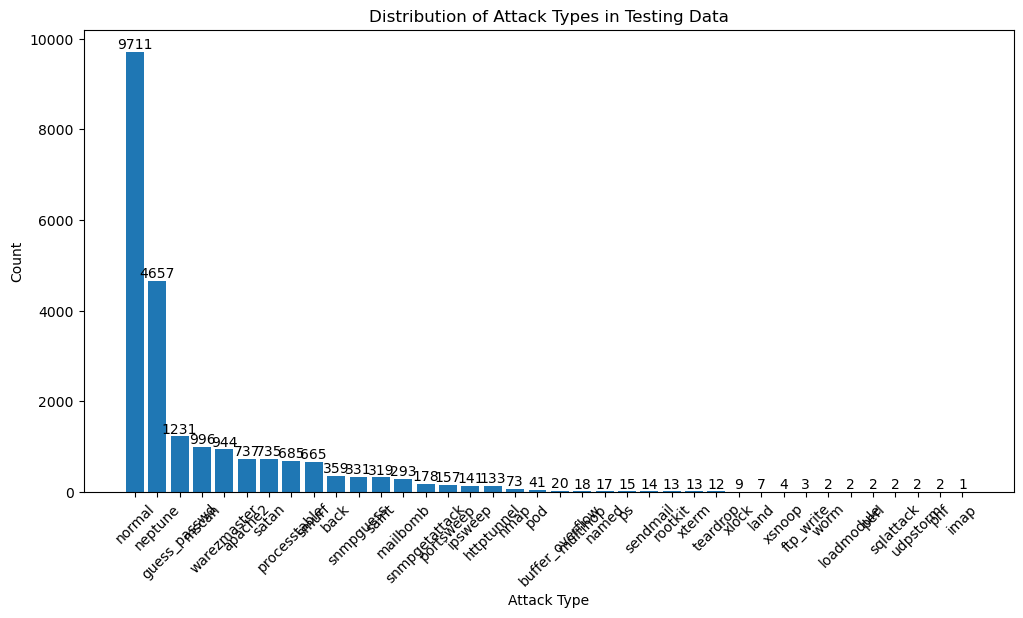

In [43]:
# Plot of Testing DDoS Attacks
attack_counts_test = df_test['attack'].value_counts()

plt.figure(figsize=(12,6))
plt.title("Distribution of Attack Types in Testing Data")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
bars = plt.bar(attack_counts_test.index, attack_counts_test.values)
add_bar_labels(bars)
plt.show()

In [44]:
# Check Types of Object
df_train.select_dtypes(['object']).columns

Index(['protocol_type', 'service', 'flag', 'attack'], dtype='object')

### Encode Data - Multiclass

In [66]:
# Encode categorical features (including 'attack')
columns_to_encode = ['protocol_type', 'service', 'flag', 'attack']
label_map = {}

for column in columns_to_encode:
    le = LabelEncoder()
    
    # Fit the label encoder only on the training data
    le.fit(df_train_multiclass[column])
    
    df_train_multiclass[column] = le.transform(df_train_multiclass[column])
    
    # Transform test data with handling for unseen labels
    df_test_multiclass[column] = df_test_multiclass[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    
    # Store the mapping for reference
    label_map[column] = dict(zip(le.classes_, le.transform(le.classes_)))

# Display the label map
for column, mapping in label_map.items():
    print(f"Mapping for {column}: {mapping}")


/var/folders/cs/q9gsmhxd20v2qj9n_hb2hv8m0000gn/T/ipykernel_53272/3758552938.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_multiclass[column] = le.transform(df_train_multiclass[column])
/var/folders/cs/q9gsmhxd20v2qj9n_hb2hv8m0000gn/T/ipykernel_53272/3758552938.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_multiclass[column] = df_test_multiclass[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
/var/folders/cs/q9gsmhxd20v2qj9n_hb2hv8m0000gn/T/ipykernel_5

Mapping for protocol_type: {'icmp': 0, 'tcp': 1, 'udp': 2}
Mapping for service: {'IRC': 0, 'X11': 1, 'Z39_50': 2, 'auth': 3, 'bgp': 4, 'courier': 5, 'csnet_ns': 6, 'ctf': 7, 'daytime': 8, 'discard': 9, 'domain': 10, 'domain_u': 11, 'echo': 12, 'eco_i': 13, 'ecr_i': 14, 'efs': 15, 'exec': 16, 'finger': 17, 'ftp': 18, 'ftp_data': 19, 'gopher': 20, 'hostnames': 21, 'http': 22, 'http_443': 23, 'imap4': 24, 'iso_tsap': 25, 'klogin': 26, 'kshell': 27, 'ldap': 28, 'link': 29, 'login': 30, 'mtp': 31, 'name': 32, 'netbios_dgm': 33, 'netbios_ns': 34, 'netbios_ssn': 35, 'netstat': 36, 'nnsp': 37, 'nntp': 38, 'ntp_u': 39, 'other': 40, 'pop_2': 41, 'pop_3': 42, 'printer': 43, 'private': 44, 'red_i': 45, 'remote_job': 46, 'rje': 47, 'shell': 48, 'smtp': 49, 'sql_net': 50, 'ssh': 51, 'sunrpc': 52, 'supdup': 53, 'systat': 54, 'telnet': 55, 'tftp_u': 56, 'tim_i': 57, 'time': 58, 'urh_i': 59, 'urp_i': 60, 'uucp': 61, 'uucp_path': 62, 'vmnet': 63, 'whois': 64}
Mapping for flag: {'OTH': 0, 'REJ': 1, 'RSTO

/var/folders/cs/q9gsmhxd20v2qj9n_hb2hv8m0000gn/T/ipykernel_53272/3758552938.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_multiclass[column] = df_test_multiclass[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)


### Removal of Features not in Network Traffic Analyzers

In [67]:
# "land," since this would have to be a check to see if src ip = dest ip
non_directly_obtainable_features = [
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'land',
    'level',   
]

x_train = df_train_multiclass.drop(non_directly_obtainable_features, axis=1)
x_test = df_test_multiclass.drop(non_directly_obtainable_features, axis=1)

### Splitting of Data

In [68]:
# Split the data into features (x) and target (y) - Level is unknown in real-time
x_train = x_train.drop('attack', axis=1)
y_train = df_train_multiclass['attack']
x_test = x_test.drop('attack', axis=1)
y_test = df_test_multiclass['attack']

In [70]:
# Ratio of Training to Testing Data
# Step 1: Determine the sizes of training and test sets
train_size = len(df_train)
test_size = len(df_test)

# Step 2: Calculate the total number of samples
total_size = train_size + test_size

# Step 3: Calculate the ratios
train_ratio = train_size / total_size
test_ratio = test_size / total_size

print(f"Train ratio: {train_ratio:.2f}")
print(f"Test ratio: {test_ratio:.2f}")


Train ratio: 0.85
Test ratio: 0.15


## Feature Engineering

In [16]:
# Mutual Information for feature selection
mutual_info = mutual_info_classif(x_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = x_train.columns
mutual_info.sort_values(ascending=False)

src_bytes                      0.931444
service                        0.762132
flag                           0.675944
diff_srv_rate                  0.656311
same_srv_rate                  0.625269
dst_host_diff_srv_rate         0.616361
count                          0.563341
dst_host_same_srv_rate         0.561941
dst_host_srv_count             0.541540
dst_bytes                      0.501865
dst_host_serror_rate           0.501065
serror_rate                    0.475274
dst_host_srv_serror_rate       0.447068
srv_serror_rate                0.425225
dst_host_same_src_port_rate    0.385678
dst_host_srv_diff_host_rate    0.324601
srv_count                      0.294895
dst_host_count                 0.293776
protocol_type                  0.260929
dst_host_rerror_rate           0.201847
srv_diff_host_rate             0.184934
dst_host_srv_rerror_rate       0.152194
rerror_rate                    0.150517
srv_rerror_rate                0.103855
duration                       0.074154


<Axes: >

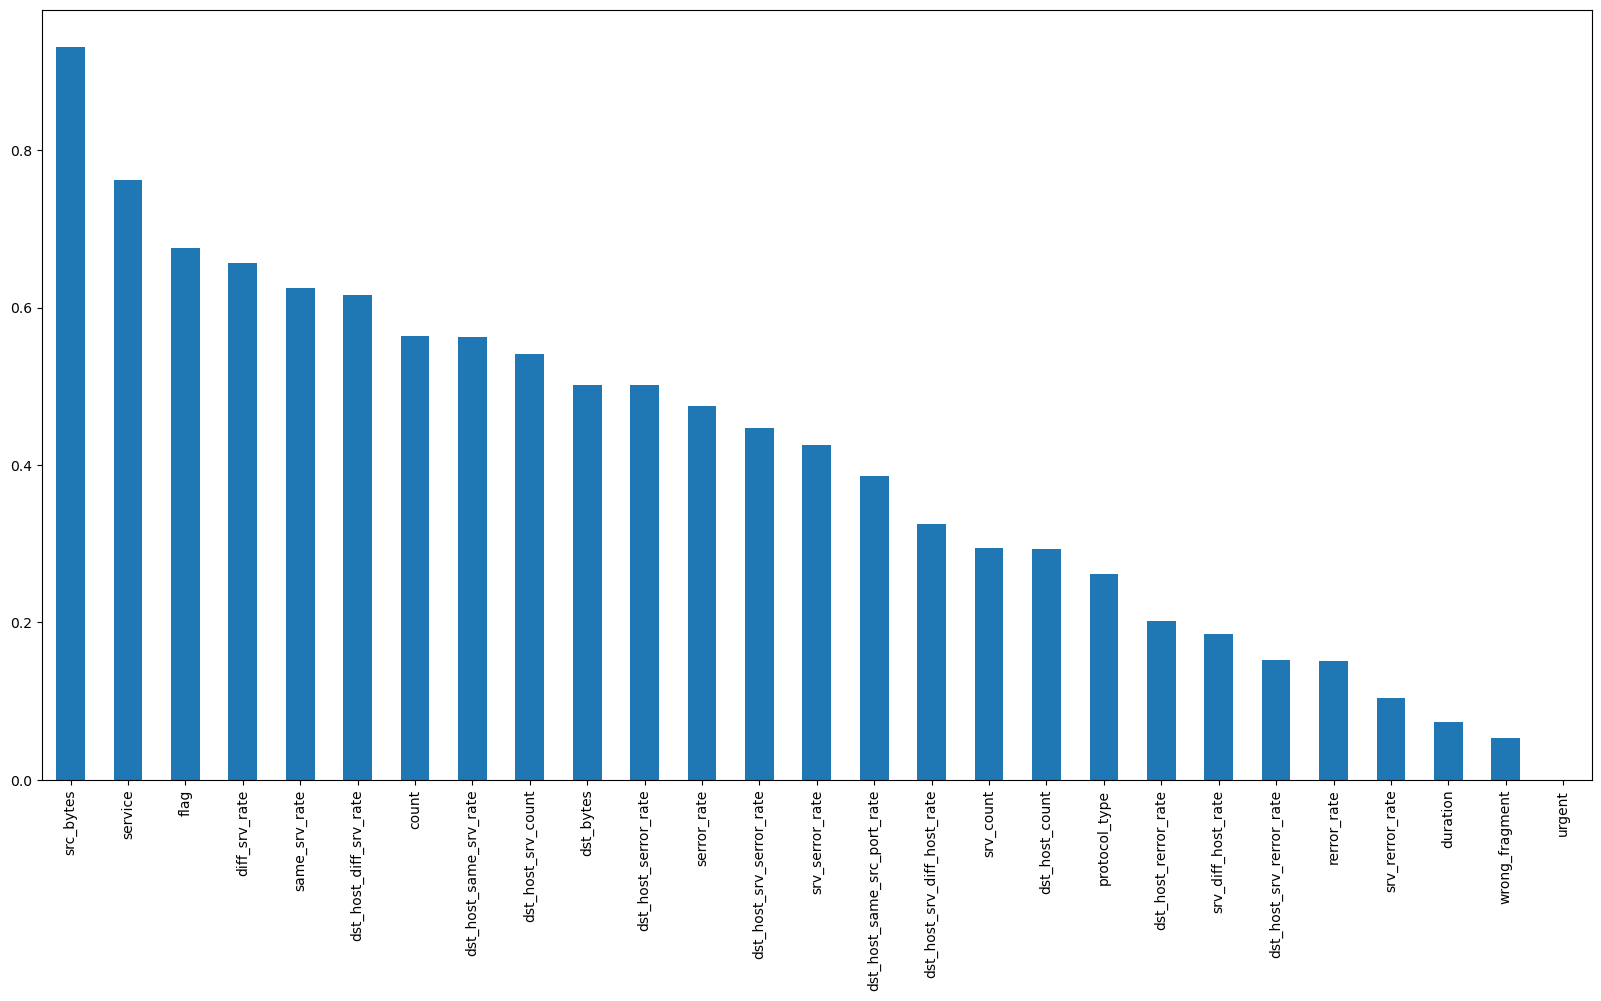

In [17]:
# Display in bar chart
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20,10))

In [49]:
# Just Drop Urgent
x_train = x_train.drop('urgent', axis=1)
x_test = x_test.drop('urgent', axis=1)


In [71]:
# SelectKBest for Top 20 Features
top_20_features = SelectKBest(mutual_info_classif, k=20)
top_20_features.fit(x_train, y_train)
x_train.columns[top_20_features.get_support()]

Index(['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate'],
      dtype='object')

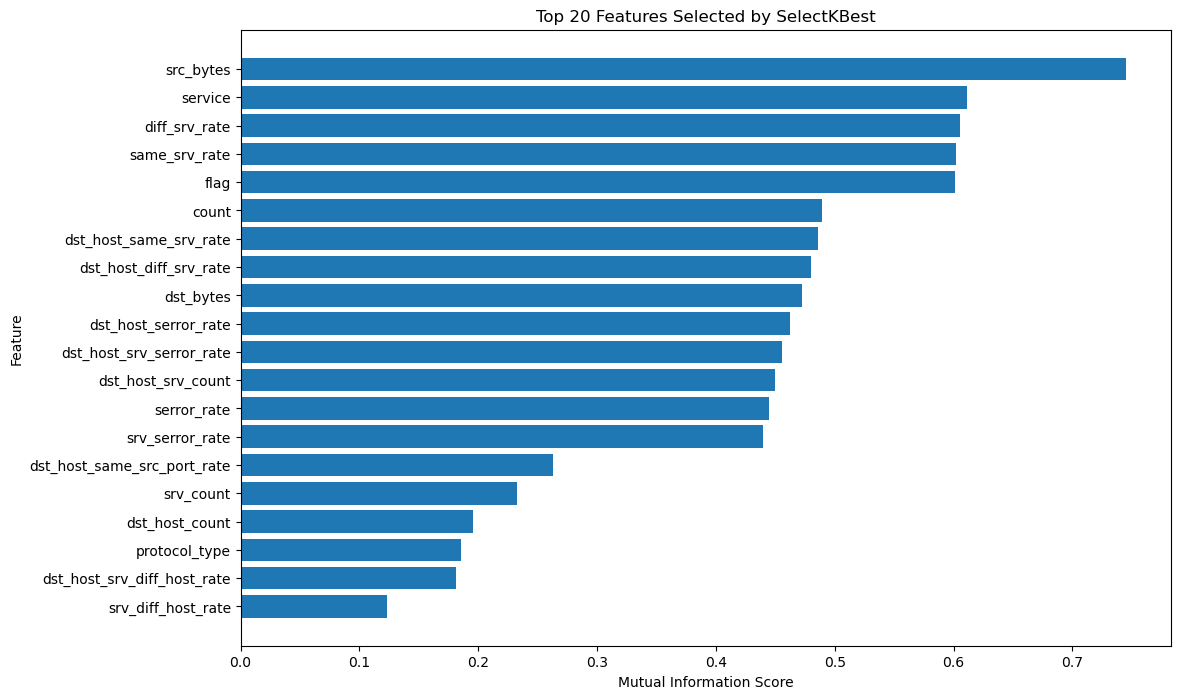

In [72]:
# Get the mask for the selected features
mask = top_20_features.get_support()

# Get the feature scores
feature_scores = top_20_features.scores_

# Get the selected feature names
selected_features = x_train.columns[mask]
selected_scores = feature_scores[mask]

# Create a DataFrame for plotting
df_top_features = pd.DataFrame({
    'Feature': selected_features,
    'Score': selected_scores
})

# Sort the DataFrame by scores in descending order
df_top_features = df_top_features.sort_values(by='Score', ascending=False)

# Plot the top features
plt.figure(figsize=(12, 8))
plt.barh(df_top_features['Feature'], df_top_features['Score'])
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Top 20 Features Selected by SelectKBest')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score on top
plt.show()


In [73]:
top_20_features = ['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate']

x_train=x_train[top_20_features]
x_test=x_test[top_20_features]

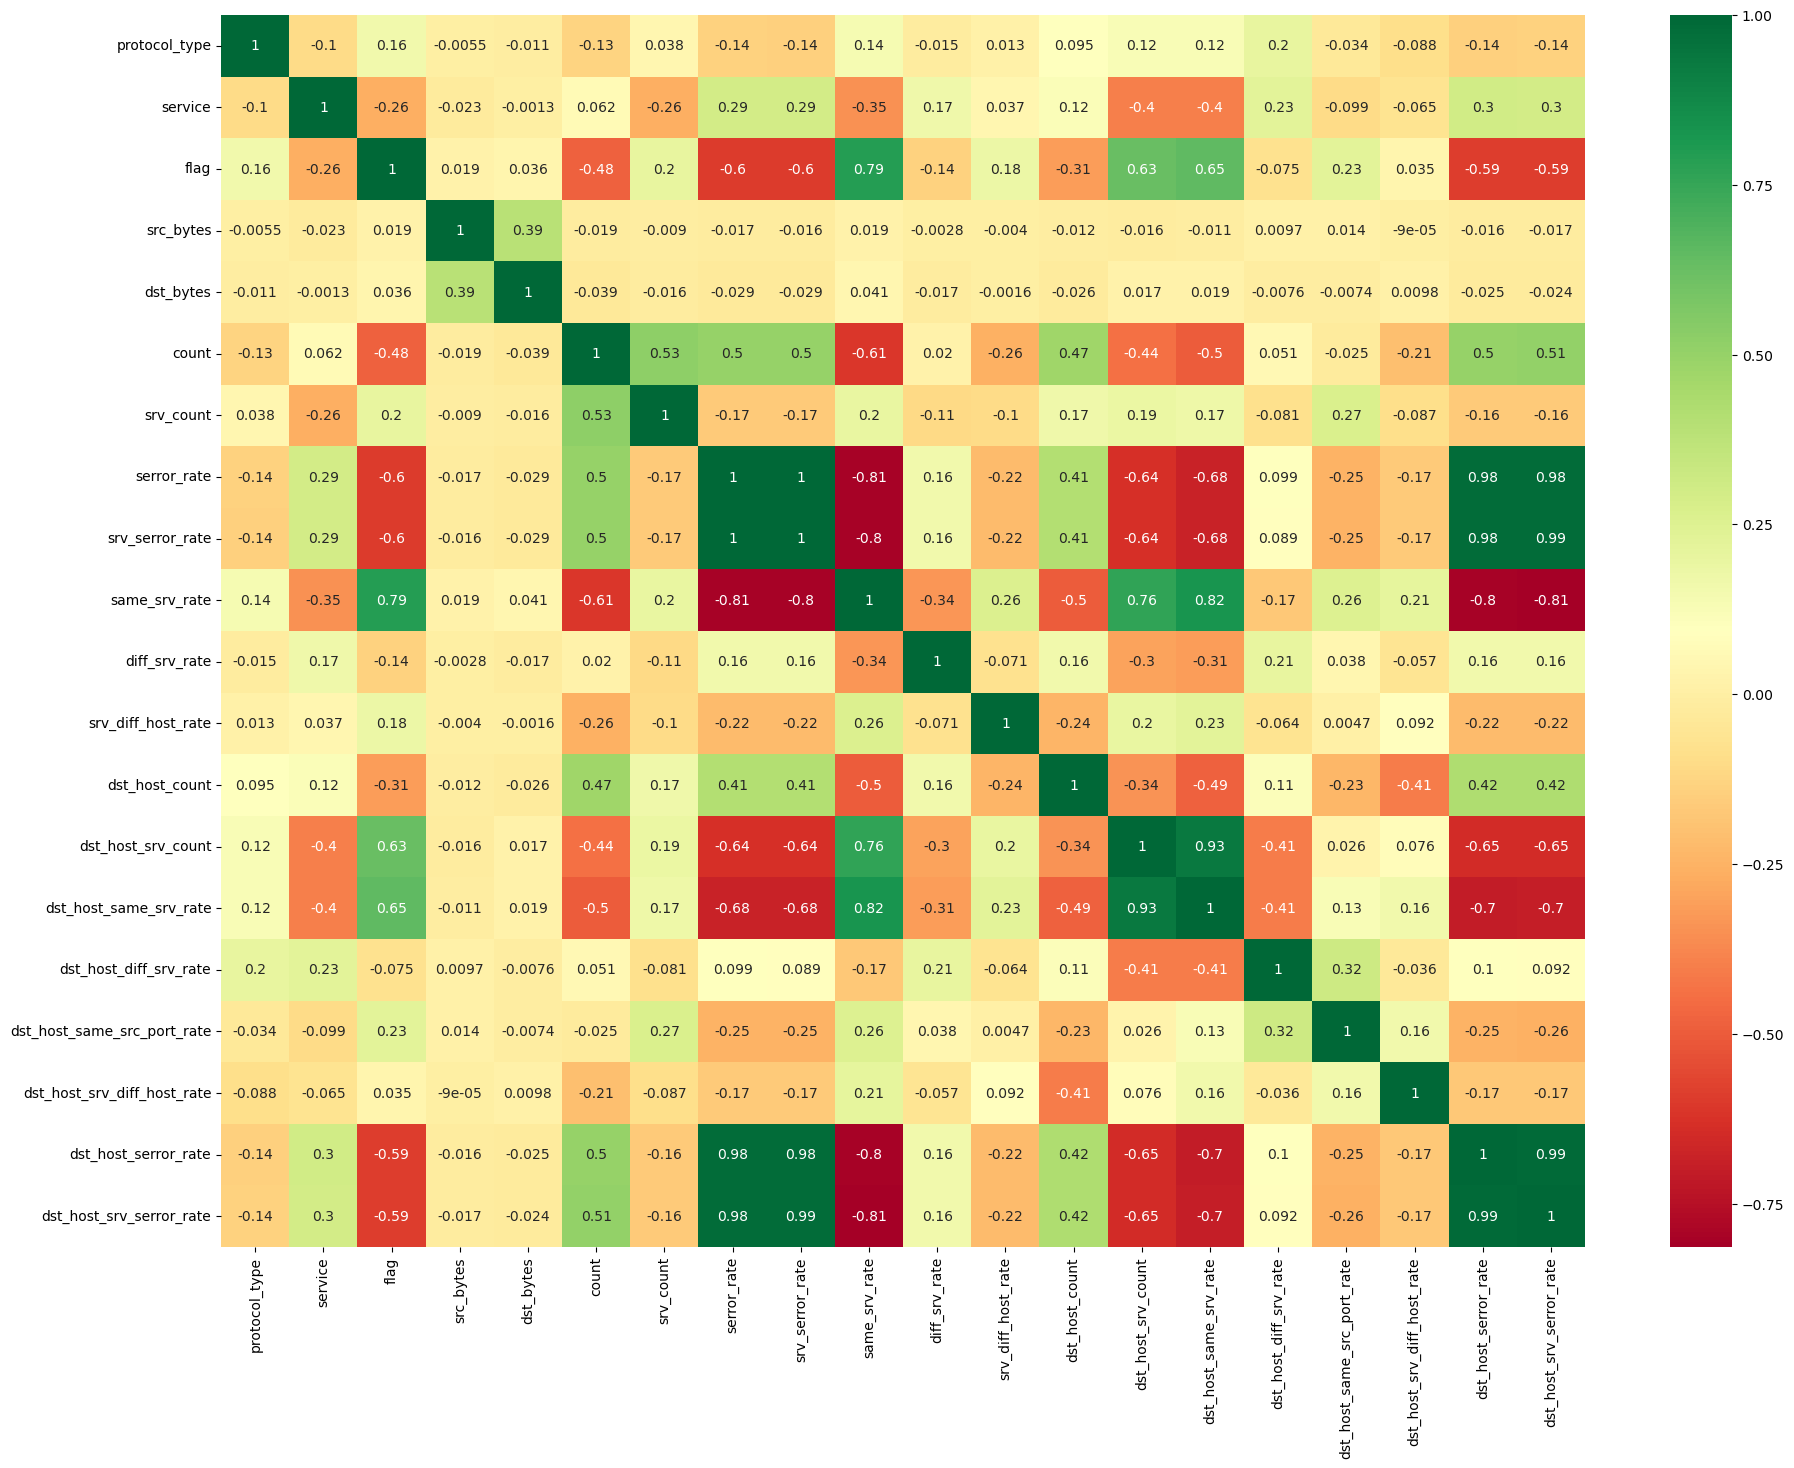

In [74]:
plt.figure(figsize=(22,16))
top_20_heatmap = sns.heatmap(x_train.corr(), annot=True, cmap='RdYlGn')

### Scaling

In [75]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
sampled = False

In [92]:
print(x_train.shape)
print(x_test.shape)

(113270, 20)
(15452, 20)


## Results of Traditional ML Models for Multiclass Classification

In [93]:
# Create the classifiers
models = {
    "XGBoost": XGBClassifier(
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Decision Tree": DecisionTreeClassifier(),
}


# Train and evaluate each model
results = {}

for name, model in models.items():
    # Train the model
    start_train_time = time.time()
    model.fit(x_train, y_train)
    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # Predict on the test set
    start_pred_time = time.time()
    y_pred = model.predict(x_test)
    end_pred_time = time.time()
    pred_time = end_pred_time - start_pred_time

    # Decode labels for evaluation
    y_test_decoded = le.inverse_transform(y_test)
    y_pred_decoded = le.inverse_transform(y_pred)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
    precision = precision_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
    recall = recall_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
    f1 = f1_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
    conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)
    class_report = classification_report(y_test_decoded, y_pred_decoded, zero_division=1, digits=5)

    # Store the results
    results[name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "conf_matrix": conf_matrix,
        "class_report": class_report,
        "train_time": train_time,
        "pred_time": pred_time
    }

    # Print evaluation metrics
    print(f'--- {name} ---')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    print(f'Classification Report:\n{class_report}')
    print(f'Training Time: {train_time} seconds')
    print(f'Prediction Time: {pred_time} seconds')


--- XGBoost ---
Accuracy: 0.9778022262490292
Precision: 0.7840644201235732
Recall: 0.840344070679181
F1 Score: 0.7121591748996231
Confusion Matrix:
[[ 249    0    0  110    0    0    0]
 [   0    2    1    4    0    0    0]
 [   0    0 4652    5    0    0    0]
 [   8    0   13 9491   44    0  155]
 [   0    0    0    3   38    0    0]
 [   0    0    0    0    0  665    0]
 [   0    0    0    0    0    0   12]]
Classification Report:
              precision    recall  f1-score   support

        back    0.96887   0.69359   0.80844       359
        land    1.00000   0.28571   0.44444         7
     neptune    0.99700   0.99893   0.99796      4657
      normal    0.98731   0.97735   0.98230      9711
         pod    0.46341   0.92683   0.61789        41
       smurf    1.00000   1.00000   1.00000       665
    teardrop    0.07186   1.00000   0.13408        12

    accuracy                        0.97780     15452
   macro avg    0.78406   0.84034   0.71216     15452
weighted avg    0.98

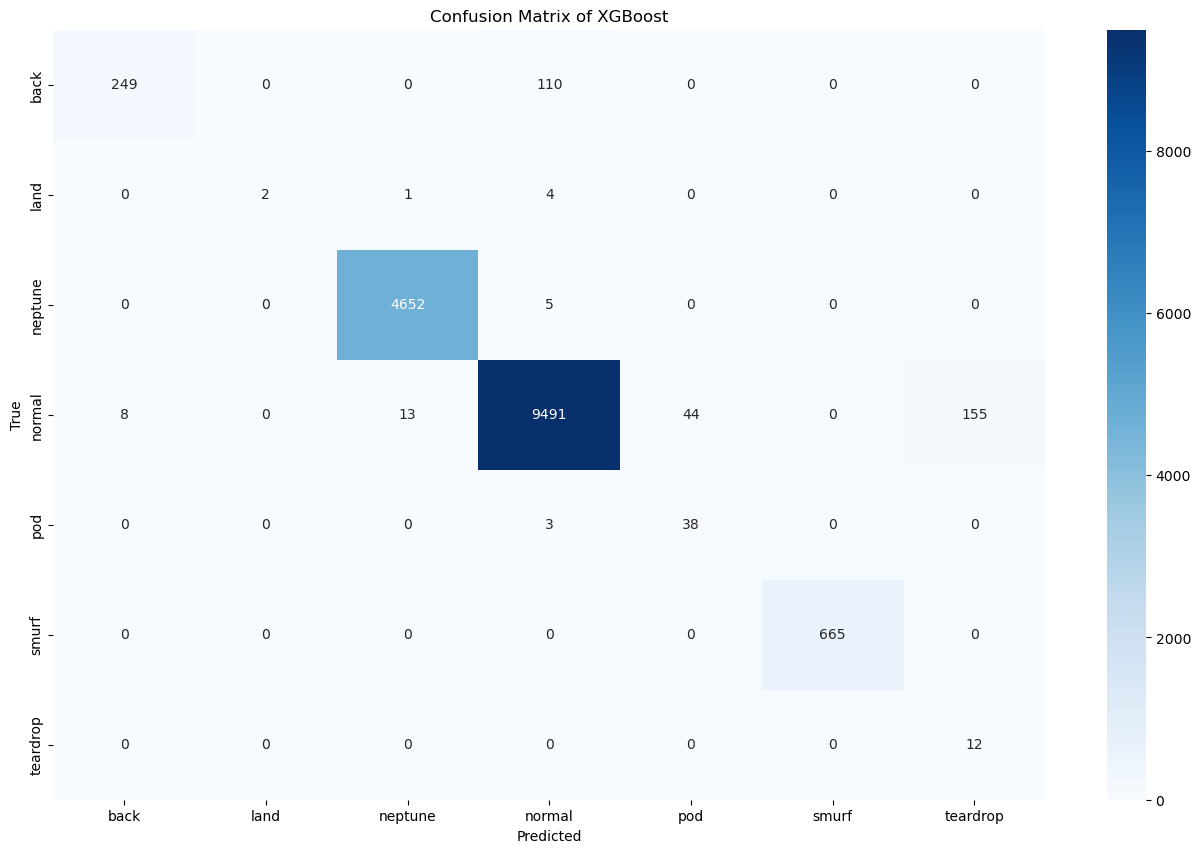

In [67]:
# Plot confusion matrix
plt.figure(figsize=(16, 10))
sns.heatmap(results['XGBoost']['conf_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of XGBoost')
plt.show()

## Deep Learning - Hybrid Model AE-XGB 

In [77]:
import tensorflow as tf
import time

### Data Reshaping

In [78]:
print(x_train.shape)
print(x_test.shape)

(113270, 20)
(15452, 20)


In [27]:
# Reshape the data for the autoencoder
balanced = False
if balanced:
    print("Balanced Version")
else:
    x_train_reshaped = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))  

x_test_reshaped = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [70]:
# Get the input dimension
input_dim = x_train_reshaped.shape[1]
print(input_dim)

20


### Autoencoder Creation

In [34]:
# Define the autoencoder model
autoencoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim, 1)),
    tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2, padding='same'),
    tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu', name='bottleneck'),
    tf.keras.layers.Dense(((input_dim // 4)) * 16, activation='relu'),
    tf.keras.layers.Reshape(((input_dim // 4), 16)),
    tf.keras.layers.UpSampling1D(2),
    tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same'),
    tf.keras.layers.UpSampling1D(2),
    tf.keras.layers.Conv1D(1, 3, activation='tanh', padding='same')
])

# Compile the autoencoder
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Print the model summary
print(autoencoder.summary())

# Extract the encoder part
encoder = tf.keras.Sequential(autoencoder.layers[:7])
encoder.build(input_shape=(None, input_dim, 1))
print(encoder.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │         1,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 16)         │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 20, 1)          │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,169 (20.19 KB)

 Trainable params: 5,169 (20.19 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │         1,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,336 (16.94 KB)

 Trainable params: 4,336 (16.94 KB)

 Non-trainable params: 0 (0.00 B)

None


### Autoencoder Training

In [35]:
autoencoder_start_time = time.time()
# Train the autoencoder on both benign and attack samples
autoencoder.fit(
    x_train_reshaped, 
    x_train_reshaped, 
    epochs=200, 
    batch_size=64, 
    shuffle=True, 
    validation_split=0.2,
)
autoencoder_end_time = time.time()
autoencoder_training_time = autoencoder_end_time - autoencoder_start_time


Epoch 1/200
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4492 - val_loss: 0.5094
Epoch 2/200
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3080 - val_loss: 0.5010
Epoch 3/200
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2908 - val_loss: 0.4978
Epoch 4/200
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3018 - val_loss: 0.4959
Epoch 5/200
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2644 - val_loss: 0.4946
Epoch 6/200
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2814 - val_loss: 0.4939
Epoch 7/200
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2802 - val_loss: 0.4931
Epoch 8/200
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2838 - val_loss: 0.4929
Epoch 9/200
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2733 - val_loss: 0.4928
Epoch 10/200
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2689 - val_loss: 0.4921
Epoch 11/200
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2950 - val_loss: 0.4926
Epoch 12/200
1416/1

### Encoding of Data using Trained Autoencoder for XGB

In [36]:
# Save the trained autoencoder model
autoencoder.save('nslkdd_trained_autoencoder.keras')

# Extract the encoder part
encoder = tf.keras.Sequential(autoencoder.layers[:7])
encoder.build(input_shape=(None, input_dim, 1))

# Print the encoder model summary
print(encoder.summary())

# Save the encoder model
encoder.save('nslkdd_trained_encoder.keras')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │         1,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,336 (16.94 KB)

 Trainable params: 4,336 (16.94 KB)

 Non-trainable params: 0 (0.00 B)

None


In [37]:
# Encode the train and test data using the trained encoder
encoded_train = encoder.predict(x_train_reshaped)
encoded_test = encoder.predict(x_test_reshaped)

3540/3540 ━━━━━━━━━━━━━━━━━━━━ 1s 371us/step
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


### Run this cell only if you saved the encoder model and want to load it

In [71]:
# Load the encoder model
encoder = tf.keras.models.load_model('nslkdd_trained_encoder.keras')

### Acquire Latent Representation for Autoencoder

In [73]:
# Encode the train and test data using the trained encoder
encoded_train = encoder.predict(x_train_reshaped)
encoded_test = encoder.predict(x_test_reshaped)

3540/3540 ━━━━━━━━━━━━━━━━━━━━ 1s 370us/step
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step


### Combine Encoded and Original Features

In [74]:
# Flatten the encoded data for training XGBoost
encoded_train_flat = encoded_train.reshape((encoded_train.shape[0], -1))
encoded_test_flat = encoded_test.reshape((encoded_test.shape[0], -1))

## Results of Hybrid AE-XGB Model

In [75]:
# Create the XGBoost classifier
model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False
)

# Train the model
start_train_time = time.time()
model.fit(encoded_train_flat, y_train, verbose=True)
end_train_time = time.time()
train_time = end_train_time - start_train_time

# Predict on the test set
start_pred_time = time.time()
y_pred = model.predict(encoded_test_flat)
end_pred_time = time.time()
pred_time = end_pred_time - start_pred_time

# Decode labels for evaluation
y_test_decoded = le.inverse_transform(y_test)
y_pred_decoded = le.inverse_transform(y_pred)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
precision = precision_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
recall = recall_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
f1 = f1_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)
class_report = classification_report(y_test_decoded, y_pred_decoded, digits=5, zero_division=1)

# Store the results
results = {}
results["xgboost"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "conf_matrix": conf_matrix,
    "class_report": class_report,
    "train_time": train_time,
    "pred_time": pred_time
}

# Print evaluation metrics
print(f'--- {"xgboost"} ---')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')
print(f'Training Time: {train_time} seconds')
print(f'Prediction Time: {pred_time} seconds')

--- xgboost ---
Accuracy: 0.983303132280611
Precision: 0.8352538661158926
Recall: 0.6979460846934282
F1 Score: 0.674051806460655
Confusion Matrix:
[[ 211    0    0  148    0    0    0]
 [   0    0    1    6    0    0    0]
 [   0    0 4622   30    0    0    5]
 [   1    0    0 9669   13    0   28]
 [   0    0    0    4   34    3    0]
 [   0    0    0   13    0  652    0]
 [   0    0    0    6    0    0    6]]
Classification Report:
              precision    recall  f1-score   support

        back       1.00      0.59      0.74       359
        land       1.00      0.00      0.00         7
     neptune       1.00      0.99      1.00      4657
      normal       0.98      1.00      0.99      9711
         pod       0.72      0.83      0.77        41
       smurf       1.00      0.98      0.99       665
    teardrop       0.15      0.50      0.24        12

    accuracy                           0.98     15452
   macro avg       0.84      0.70      0.67     15452
weighted avg       0.

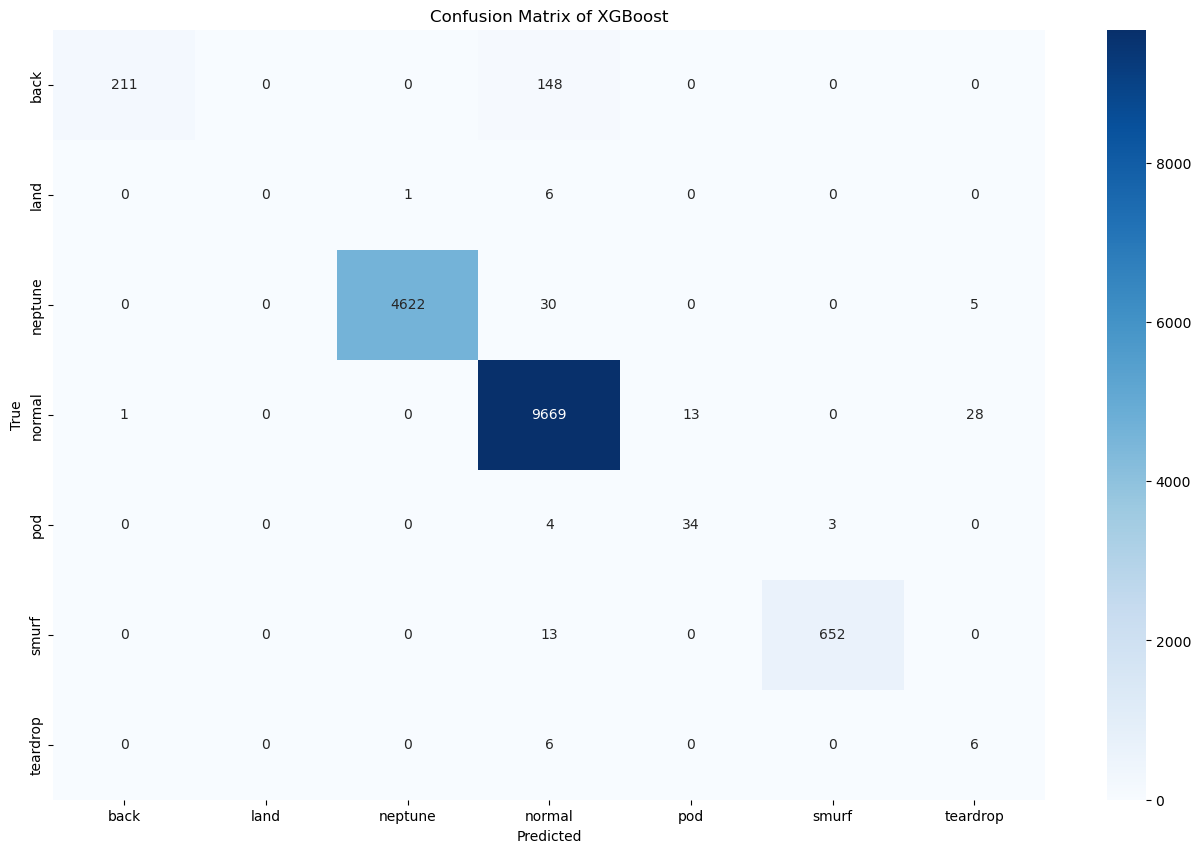

In [76]:
# Plot confusion matrix
plt.figure(figsize=(16, 10))
sns.heatmap(results['xgboost']['conf_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of XGBoost')
plt.show()

## Deep Learning - CNN-LSTM

### Model Creation



In [98]:
# Reshape x_train and x_test to 3D for CNN-LSTM
x_train_reshaped = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))  # shape becomes (125973, 20, 1)
x_test_reshaped = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))      # shape becomes (22544, 20, 1)


In [100]:
num_classes = 7  # Adjust this based on your actual number of classes

cnn_lstm_model = tf.keras.models.Sequential([
    # Input shape is (20 time steps, 1 feature per time step)
    tf.keras.layers.Input(shape=(x_train.shape[1], 1)),
    
    # CNN Layers with adjusted pooling
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),  # This reduces the time steps from 20 to 10
    
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),  # This reduces the time steps from 10 to 5
    
    # LSTM Layers
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100),
    
    # Fully Connected Layers
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    
    # Output layer for multiclass classification
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Softmax for multiclass classification
])

# Compile the model
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
cnn_lstm_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 18, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 7, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 3, 100)         │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 200)            │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         1,407 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,159 (754.53 KB)

 Trainable params: 193,159 (754.53 KB)

 Non-trainable params: 0 (0.00 B)

In [97]:
# Convert y_train and y_test to one-hot encoding
y_train_reshaped = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_reshaped = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

print(y_train_reshaped.shape)  # Should print (125973, 7)
print(y_test_reshaped.shape)   # Should print (22544, 7)


(113270, 7)
(15452, 7)


In [101]:
import time

# Record the start time
start_time = time.time()

# Train the model
history = cnn_lstm_model.fit(x_train_reshaped, y_train_reshaped, epochs=30, batch_size=64, validation_data=(x_test_reshaped, y_test_reshaped))

# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

# Print the training time
print(f"Training time: {training_time:.2f} seconds")


Epoch 1/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9302 - loss: 0.2332 - val_accuracy: 0.9740 - val_loss: 0.0850
Epoch 2/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9938 - loss: 0.0204 - val_accuracy: 0.9876 - val_loss: 0.0502
Epoch 3/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9963 - loss: 0.0118 - val_accuracy: 0.9834 - val_loss: 0.0664
Epoch 4/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9973 - loss: 0.0092 - val_accuracy: 0.9925 - val_loss: 0.0295
Epoch 5/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9977 - loss: 0.0073 - val_accuracy: 0.9902 - val_loss: 0.0443
Epoch 6/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9974 - loss: 0.0089 - val_accuracy: 0.9919 - val_loss: 0.0439
Epoch 7/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9983 - loss: 0.0056 - val_accuracy: 0.9897 - val_loss: 0.0620
Epoch 8/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9984 - loss: 0

In [102]:
loss, accuracy = cnn_lstm_model.evaluate(x_test_reshaped, y_test_reshaped)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9902 - loss: 0.1115
Test Loss: 0.12339672446250916
Test Accuracy: 0.9882215857505798


In [103]:
# Make predictions on the test data
start_pred_time = time.time()
y_pred = cnn_lstm_model.predict(x_test_reshaped)
end_pred_time = time.time()
pred_time = end_pred_time - start_pred_time
print(f"Prediction time: {pred_time:.2f} seconds")

# Convert predictions from probabilities to class labels (argmax to get the index of the max probability)
y_pred_classes = np.argmax(y_pred, axis=1)

# y_test is one-hot encoded, so you need to reverse that
y_true_classes = np.argmax(y_test_reshaped, axis=1)

# Decode the integer-encoded labels back to the original categorical labels using LabelEncoder
y_pred_decoded = le.inverse_transform(y_pred_classes)
y_test_decoded = le.inverse_transform(y_true_classes)

# Print the decoded predictions and true labels
print("Predicted Labels:", y_pred_decoded)
print("True Labels:", y_test_decoded)


483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Prediction time: 1.07 seconds
Predicted Labels: ['neptune' 'neptune' 'normal' ... 'normal' 'back' 'normal']
True Labels: ['neptune' 'neptune' 'normal' ... 'normal' 'back' 'normal']


In [104]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
precision = precision_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
recall = recall_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
f1 = f1_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision (macro-average): {precision:.5f}")
print(f"Recall (macro-average): {recall:.5f}")
print(f"F1 Score (macro-average): {f1:.5f}")


Accuracy: 0.98822
Precision (macro-average): 0.70967
Recall (macro-average): 0.87052
F1 Score (macro-average): 0.73879


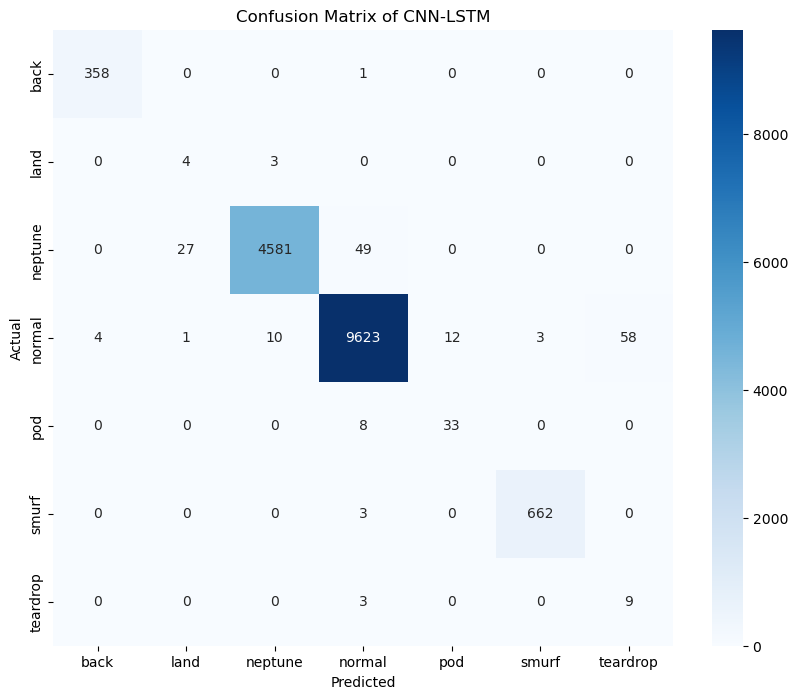

              precision    recall  f1-score   support

        back    0.98895   0.99721   0.99307       359
        land    0.12500   0.57143   0.20513         7
     neptune    0.99717   0.98368   0.99038      4657
      normal    0.99339   0.99094   0.99216      9711
         pod    0.73333   0.80488   0.76744        41
       smurf    0.99549   0.99549   0.99549       665
    teardrop    0.13433   0.75000   0.22785        12

    accuracy                        0.98822     15452
   macro avg    0.70967   0.87052   0.73879     15452
weighted avg    0.99277   0.98822   0.99024     15452



In [106]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

# Define the number of classes (assuming le.classes_ gives the correct number of classes)
num_classes = len(le.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of CNN-LSTM')
plt.show()

# Print the classification report
print(classification_report(y_test_decoded, y_pred_decoded, digits=5))
